In [1]:
import urllib.request
import json
from datetime import datetime, date, timedelta

import networkx as nx
import math
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
from scipy.stats import norm
import statistics
import folium
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from fredapi import Fred

from sklearn.linear_model import LinearRegression 
import piecewise_regression as pwr

In [2]:
# ---- Settings ----
page_title = "Data Analytics with Real World Data: Gas Receipts"
layout = "centered"
# ------------------

# ---- Variables ----
liesel_buy = datetime(2019,6,21)
pandemic_st = datetime(2020,3,11)
pandemic_end= datetime(2022,4,13)
rto = datetime(2023,4,17)
# -------------------

# ---- external data ----
fred= Fred(api_key='a0422a022699ba22a37f77ac785e6bed')
data={}
data['gas']=fred.get_series('GASREGW',observation_start=liesel_buy)
data=pd.DataFrame(data)
data['mdate']=pd.to_datetime(data.index)
data=data[['mdate','gas']]

# ---- internal data ----
fpath = "https://raw.githubusercontent.com/markspotsthex/Liesel/main/Liesel_Fuel_History.json"
with urllib.request.urlopen(fpath) as url:
    fh = json.load(url)

loc_df=pd.DataFrame([[station['stationName'],station['attributes']['location']['latitude'],station['attributes']['location']['longitude'],station['attributes']['location']['county']] for station in fh['stations'] if station['attributes']['location']['address']!="Unknown"],columns=['Name','Latitude','Longitude','County'])
loc_col={'Cook (IL)':"blue",'Lake (IL)':"green",'Will (IL)':"red",'McLean (IL)':"red"}
loc_df['col']=loc_df['County'].map(loc_col)

df_stops = pd.DataFrame(fh['stops']).sort_values(by=['datetime'])
# date variables
df_stops['datetime']=pd.to_datetime(df_stops['datetime'])
df_stops['mdate']=pd.to_datetime(df_stops['datetime'].dt.date)-pd.tseries.offsets.Week(weekday=0)
df_stops['dtindex']=(df_stops['datetime']-liesel_buy).dt.days
# cumulative variables
df_stops['fcost']=df_stops['credit'].cumsum()
df_stops['ttrip']=df_stops['trip'].cumsum()
# difference variables
df_stops['miles_diff']=df_stops['miles'].diff()
df_stops['dtbetween']=df_stops['dtindex'].diff()
# populate first row in difference variables
df_stops['miles_diff']=df_stops['miles_diff'].fillna(df_stops['miles'])
df_stops['dtbetween']=df_stops['dtbetween'].fillna(df_stops['dtindex'])
# computed variables
df_stops['mpg']=df_stops['miles_diff']/df_stops['gal']
df_stops['daily_mi']=df_stops['miles_diff']/df_stops['dtbetween']


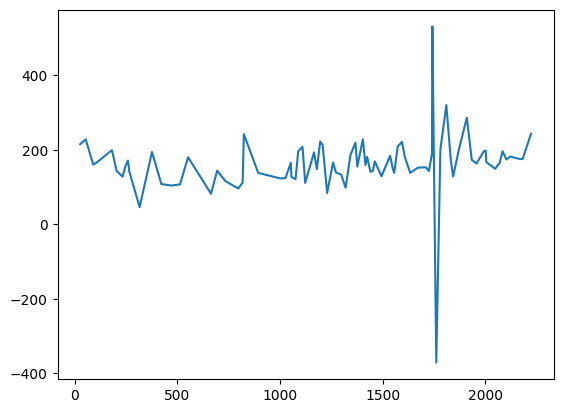

In [12]:
plt.plot(df_stops['dtindex'],df_stops['miles_diff'])
plt.show()